This generates gblocks of designs from fasta files. The clusters can be specified in to 8 or 12 to fit a 96 well plate. 

Take difference between minimum and maximum of design based on name. Next, use kmeans to cluster designs into N-number of
cluster points. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from Bio.Restriction import *
from Bio.Seq import Seq
from datetime import date
from Bio.Alphabet import generic_dna, generic_protein
today = date.today()

In [3]:
# inputfile to be defined by the user
ref_dna_file = "AP-HT_input_vector_BsaI_scrubbed.fa"
designs_aa_fasta_file = "init_designs.fasta"
codon_table_file = "codon-usage_Plentus.txt"
# number of clusters to divide the sequences into
cluster_size = 12
ofile = str(today)+"_data"

In [4]:
def get_fasta_sequence(designs_aa_fasta_file):
    sequences_ = {}
    with open(designs_aa_fasta_file, 'r') as f:
        for line in f:
            if (line[0] == ">"):
                tmp = line.split()
                ids = tmp[0]
                sequences_[ids] = ""
            else:
                tmp = line.strip()
                sequences_[ids] = sequences_[ids] + tmp
    return sequences_

In [5]:
# make sure that the names are correct with respect to the reference sequence
import sys
sys.path.append("/Users/pgreisen/pythonscripts/develop/insert_mutation_into_DNA_string")
import InsertSubstitutions
ris = InsertSubstitutions.InsertSubstitutions()

# get reference DNA
ref_dna = get_fasta_sequence(ref_dna_file)
# get the AA sequence of the designs
sequences = get_fasta_sequence(designs_aa_fasta_file)
ref_key = list(ref_dna.keys())[0]

In [6]:
# Rename sequence to reference DNA
ref_dna_bp = Seq(ref_dna[ref_key])
ref_dna_peptide_seq = ref_dna_bp.translate()

In [7]:
import sys
sys.path.append("/Users/pgreisen/pythonscripts/develop/RenameToNative")
import RenameRelativeToNativeSeq as rrn
r_ = rrn.DiffFasta()

In [8]:
sequences_renamed = {}
for i in sequences.keys():
    var_ = r_.diff_sequence_a_b(ref_dna_peptide_seq, sequences[i])
    sequences_renamed[var_[:-1]] = sequences[i]

In [9]:
# Insert substitutions into DNA string
dna_seqs = {}
for key in sequences_renamed.keys():
    stop_of_list = -1
    mut_header = ""
    tmpheader = key.split('_')
    integer_ = isinstance(tmpheader[-1], int)
    if(integer_ == False):
        stop_of_list = len(tmpheader)
    for i in tmpheader[0:stop_of_list]:
        mut_header += i+"_"
    fastaheader, sequence = ris.run( ref_dna_file, codon_table_file, mut_header[:-1])
    assert len(sequence) == len(ref_dna[ref_key])
    dna_seqs[fastaheader] = sequence

In [10]:
import pandas as pd
# parameters needed for the run
# bsaI sites for cloning
preseq = "GTCACGGTCTCA"
postseq = "CGAGACCAGTCA"
# range of basepair offset
bp_offset_nterm = 3
bp_offset_cterm = 3
bp_offset = 3
# variable parameter for the gene length
# g-blocks to synthetize
cutoff = [250,500,750,1000]

In [11]:
# prices taken from here (Tubes): 
# https://www.idtdna.com/pages/products/genes-and-gene-fragments/gblocks-gene-fragments
idt_gblock = {
    250 : 71.10,
    500 : 71.10,
    750 : 80.10,
    1000 : 89.10,
    1250 : 143.10
}

In [12]:
def get_price(length):
    ln = int(length)
    if ln <= 250:
        return 71.10
    elif ln <= 500: 
        return 71.10
    elif ln <= 750:
        return 80.10
    elif ln <= 1000:
        return 89.10
    elif ln <= 1250:
        return 143.10
    elif ln <= 1500:
        return 179.1
    else:
        return "Error"

In [13]:
def write_fasta_file_w_variants(df):
    lengt = []
    with open(ofile+".fasta",'w') as f:
        for i, varname, dnaseq, st, end in zip(df.index, df["VarName"],df["seq(DNA)"],df["start_cut_DNA"],df["end_cut_DNA"]):
            f.write(varname+"\n")
            lengt.append(len(preseq+dnaseq[st:end]+postseq))
            idt_seq_ = preseq+dnaseq[st:end]+postseq
            a = Analysis(restrictionbatch=RestrictionBatch(['BsaI']),sequence=Seq(idt_seq_) )
            prot_sites_ = a.full()
            prot_key = list(prot_sites_.keys())[0]
            cutsites = ', '.join(map(str, prot_sites_[prot_key]))
            df.iloc[i, df.columns.get_loc("bsaI_sites")] = cutsites
            df.iloc[i, df.columns.get_loc("IDT_gene")] = idt_seq_
            f.write(idt_seq_+"\n")
    return df

In [14]:
def read_fastafile(ifile):
    sequences = {}
    with open(ifile,'r') as f:
        for line in f:
            if(line[0] == ">"):
                tmp = line.split()
                ids = tmp[0]
                sequences[ids] = ""
            else:
                tmp = line.strip()
                sequences[ids] = sequences[ids] + tmp
    return sequences

In [15]:
def reassign_missing_variants(df):
    '''
    '''
    reassign_cluster = {}
    # sub-divide the rest into exciting cluster
    for i,j,k,c,l in zip(df.index, df["start_DNA_w_padding"], df["end_DNA_w_padding"], df["Clustered"],df["Size_of_gene"]):
        if(c == 0):
            for key in dict_w_start_stop:
                if( (j >= dict_w_start_stop[key][0]) & (k <= dict_w_start_stop[key][1])):
                    # add and sort such that we can add it to the
                    # shortest gene cluster
                    tmpkey = "index_"+str(i)
                    reassign_cluster[tmpkey] = (i,j,k,c,key,dict_w_start_stop[key][2])
    # sort dictionary
    listofTuples = sorted(reassign_cluster.items() ,  key=lambda x: x[-1] )
    r_c = dict(listofTuples)
    for key in reassign_cluster.keys():
        df.iloc[r_c[key][0], df.columns.get_loc("Clustered")] = 1
        df.iloc[r_c[key][0], df.columns.get_loc("Cluster_name")] = r_c[key][4]
        df.iloc[r_c[key][0], df.columns.get_loc("Size_of_gene")] = r_c[key][5]
    return df

In [16]:
# Create a dataframe with the AA and DNA sequences
df_sequences = pd.DataFrame.from_dict(dna_seqs,orient='index',columns=['seq(DNA)'] )
df_sequences.reset_index(inplace=True)
df_sequences = df_sequences.rename(columns={'index':'VarName'})
df_sequences["VarName"] = df_sequences["VarName"].str.replace(">","")

In [17]:
def set_residue_numbers(seq_df):
    # initialize new columns
    seq_df["start_DNA"] = 0 
    seq_df["end_DNA"] = 0 
    # loop over keys in hash
    # Contain all the positions mutated
    residue_nr = []
    # contains residue numbers for each variant
    tmpresiduenr = {}
    for index, varname in zip(seq_df.index, seq_df["VarName"]):
        new_array = []
        nametmp_ = varname.split("_")
        for j in nametmp_:
            new_array.append( int(j[1:-1] ) )
        mn = min(new_array)
        mx = max(new_array)
        # The -3 is due to counting from 0 and protein vs DNA
        seq_df.iloc[index,seq_df.columns.get_loc("start_DNA")] = 3*mn-3
        # 
        seq_df.iloc[index,seq_df.columns.get_loc("end_DNA")] = 3*mx
    return seq_df

In [18]:
df_sequences = set_residue_numbers(df_sequences)
df_sequences["start_DNA_w_padding"] = df_sequences["start_DNA"] - bp_offset
df_sequences["end_DNA_w_padding"] = df_sequences["end_DNA"] + bp_offset

In [19]:
df_sequences.sort_values(by=["start_DNA_w_padding","end_DNA_w_padding"],inplace=True)
df_sequences["length_DNA_w_padding"] = df_sequences["end_DNA_w_padding"] - df_sequences["start_DNA_w_padding"]

In [20]:
df_sequences["Clustered"] = 0
df_sequences["Cluster_name"] = ""
df_sequences["Size_of_gene"] = 0

In [21]:
def get_clusters(df,min_size_cluster,cutoff,gb="start_DNA_w_padding", parameter="length_DNA_w_padding"):
    # remove lengths greater than cutoff
    temp = df[(df[parameter] < cutoff) & (df["Clustered"] != 1) ]
    # count how many 
    tmp_= temp.groupby(gb).count().reset_index()
    # only clusters of certain size are investigated
    tmp_ = tmp_[tmp_["VarName"] >= min_size_cluster]
    return tmp_

def set_clusters(df,init_values, cutoff):
    for i,j,l,c in zip(df.index, df["start_DNA_w_padding"], df["length_DNA_w_padding"],df["Clustered"]):
        
        # bool value so you dont overwrite existing clusters
        if(c == 1):
            continue
        elif((j in init_values) & (l < cutoff)):
            df.iloc[i, df.columns.get_loc("Clustered")] = 1
            df.iloc[i, df.columns.get_loc("Cluster_name")] = "cluster_"+str(j)+"_"+str(j+cutoff)+"_"+str(cutoff)
            df.iloc[i, df.columns.get_loc("Size_of_gene")] = cutoff
        else:
            continue
    return df
df = df_sequences.copy()
df = df.reset_index()

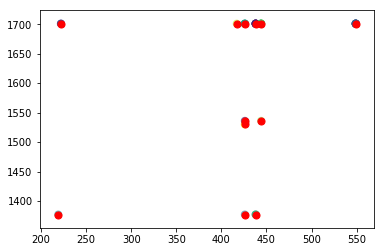

In [22]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
df_cluster = DataFrame(df,columns=['start_DNA_w_padding', 'end_DNA_w_padding'])
kmeans = KMeans(n_clusters=cluster_size).fit(df_cluster)
centroids = kmeans.cluster_centers_
plt.scatter(df_cluster['start_DNA_w_padding'], df_cluster['end_DNA_w_padding'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [23]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df.index.values
cluster_map['cluster'] = kmeans.labels_

In [24]:
# merge dataframes
df_kmeans = pd.merge(right=df, right_index=True, left=cluster_map, left_index=True)

In [25]:
df_kmeans.drop(labels=['data_index', 'index',\
                       'start_DNA_w_padding', 'end_DNA_w_padding','length_DNA_w_padding',\
                       'Clustered','Size_of_gene','Cluster_name'], axis=1,inplace=True)

In [26]:
nr_clusters = list(set(kmeans.labels_))
df_kmeans['start_cut_DNA'] = 0
df_kmeans['end_cut_DNA'] = 0
df_kmeans['Size_of_gene'] = 0
df_kmeans['Cluster_name'] = ""

for cluster_ in nr_clusters:
    # get each cluster
    subcluster = df_kmeans[df_kmeans['cluster'] == cluster_]
    # start cut DNA
    mn_ = min(subcluster['start_DNA'])
    # end cut DNA
    mx_ = max(subcluster['end_DNA'])
    # size of gene
    length_ = mx_-mn_
    # cluster name
    clustername_ = "Cluster_"+str(mn_)+"_"+str(mx_)+"_cluster_nr_"+str(cluster_)
    for i in df_kmeans.index:
        if(df_kmeans.iloc[i,df_kmeans.columns.get_loc('cluster')] == cluster_):
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('start_cut_DNA')] = mn_ - bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('end_cut_DNA')] = mx_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Size_of_gene')] = length_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Cluster_name')]= clustername_

In [28]:
# Calculate price
df_kmeans["IDT_price"] = df_kmeans["Size_of_gene"].apply(get_price)
print("The price of the order is: ",df_kmeans["IDT_price"].sum())
print("Number of unique cluster: ", len(df_kmeans["Cluster_name"].unique()))
tmp = df_kmeans.groupby("Cluster_name").count()
print("Size of the different clusters: ",tmp["VarName"] )

The price of the order is:  7660.799999999999
Number of unique cluster:  12
Size of the different clusters:  Cluster_name
Cluster_222_1374_cluster_nr_5      1
Cluster_225_1698_cluster_nr_2      3
Cluster_420_1698_cluster_nr_10     1
Cluster_429_1374_cluster_nr_4      1
Cluster_429_1527_cluster_nr_11     2
Cluster_429_1533_cluster_nr_0      1
Cluster_429_1698_cluster_nr_6      5
Cluster_441_1374_cluster_nr_7      3
Cluster_441_1698_cluster_nr_1     10
Cluster_447_1533_cluster_nr_9      1
Cluster_447_1698_cluster_nr_8      9
Cluster_552_1698_cluster_nr_3     11
Name: VarName, dtype: int64


In [29]:
# sets the IDT gene and bsaI cut-sites
df_kmeans["bsaI_sites"] = ""
df_kmeans["IDT_gene"] = ""
df_kmeans = write_fasta_file_w_variants(df_kmeans)

In [30]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein
df_kmeans["AA_seq"] = ""
for i,j in zip(df_kmeans.index, df_kmeans["IDT_gene"]):
    tmpseq_ = j[len(preseq):-len(postseq)]
    my_seq = Seq(tmpseq_)
    df_kmeans.iloc[i,df_kmeans.columns.get_loc("AA_seq")] = my_seq.translate()

In [31]:
df_kmeans.to_excel(ofile+".xlsx",index=False)

with open("aa_test.fasta",'w') as f:
    for i,j in zip(df_kmeans["VarName"],df_kmeans["AA_seq"]):
        f.write(">"+i+"\n")
        f.write(str(j)+"\n")